In [11]:
import pandas as pd 
import numpy as np
from datetime import datetime
from typing import Tuple
import warnings
warnings.filterwarnings('ignore')

base_path = 'D:/dneuro/research/'
output_path = 'D:/dneuro/research/output/summary/NFL2/'

df_return = pd.read_pickle(base_path + '/tpx500_historical_total_return_2000_2025_0213.pkl')
df_fx = pd.read_pickle(base_path + '/tpx500_msfxjpy_index_price_2000_2025.pkl')

df_return = df_return.reindex(sorted(df_return.columns, key=str), axis=1)

df_fx.columns = ['MSFXJPY Index']
df_fx['pct_change'] = df_fx['MSFXJPY Index'].pct_change()

def build_usd_return(df_fx: pd.DataFrame, df_return: pd.DataFrame) -> pd.DataFrame:

    common_dates = df_fx.index.intersection(df_return.index)

    df_fx_filtered = df_fx.loc[common_dates]

    df_return_filtered = df_return.loc[common_dates]

    tickers = df_return.columns.tolist()
    df_fx_filtered['pct_change_plus_1'] = df_fx_filtered['pct_change'] + 1

    df_return_filtered = (1+df_return_filtered).multiply(df_fx_filtered['pct_change_plus_1'], axis=0) - 1
    df_return_filtered = df_return_filtered[tickers]
    return df_return_filtered


def build_same_setting_dataframe(df_a: pd.DataFrame, df_b: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]: 
    # Find common tickers using set intersection (faster than list comprehension)
    common_tickers = sorted(set(df_a.columns) & set(df_b.columns))

    # Select only common tickers in sorted order
    return df_a[common_tickers], df_b[common_tickers]

def calc_portfolio_return(df_return: pd.DataFrame, df_factor: pd.DataFrame, lagging: int = 0)-> pd.DataFrame:

    df_weight_mul_return = df_factor * df_return.shift(-lagging)
    df_portfolio_return = df_weight_mul_return.sum(axis=1)
    df_portfolio_return = df_portfolio_return.shift(lagging)
    df_portfolio_return = pd.DataFrame(df_portfolio_return, columns = ['return'], index = df_portfolio_return.index)

    return df_portfolio_return

df_usd_return = build_usd_return(df_fx, df_return)
df_usd_return.index = pd.to_datetime(df_usd_return.index)

In [ ]:
# Universe: Topix 500 Constituents Only
# Trade Value Filter: Average Trade Value of USD 5M
# Main Data: Japan Securities Lending 
# Average number of Holdings: between 400 and 450
# Average daily turnover: about 29.5%
# recent 10-year sharpe ratio / recent 15-year sharpe ratio: 1.64 / 1.41
# Target Portfolio Size: 20M USD (1% of average trade value * 400 holdings)

In [13]:
df_factor1 = pd.read_excel(output_path + 'NFL2_factor1_weights.xlsx', index_col=0)
df_factor2 = pd.read_excel(output_path + 'NFL2_factor2_weights.xlsx', index_col=0)

common_dates = df_factor1.index \
.intersection(df_factor2.index) 

df_factor1 = df_factor1.loc[common_dates]
df_factor2 = df_factor2.loc[common_dates]

common_dates = df_usd_return.index.intersection(df_factor1.index)
df_factor1 = df_factor1.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor1 = build_same_setting_dataframe(df_usd_return_filtered, df_factor1)
df_factor1_return = calc_portfolio_return(df_usd_return_filtered, df_factor1, 1)

common_dates = df_usd_return.index.intersection(df_factor2.index)
df_factor2 = df_factor2.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]
df_usd_return_filtered, df_factor2 = build_same_setting_dataframe(df_usd_return_filtered, df_factor2)
df_factor2_return = calc_portfolio_return(df_usd_return_filtered, df_factor2, 1)

df_returns = pd.concat([df_factor1_return['return'], df_factor2_return['return']], axis=1)
df_returns.index = df_factor1_return.index
df_corr = df_returns.corr()
df_corr.columns = ['factor1','factor2']
df_corr.index = ['factor1','factor2']
df_corr

,factor1,factor2
factor1,1.000000,0.697068
factor2,0.697068,1.000000


1.1705531700204486
1.4133173037374906
1.6411764024241793


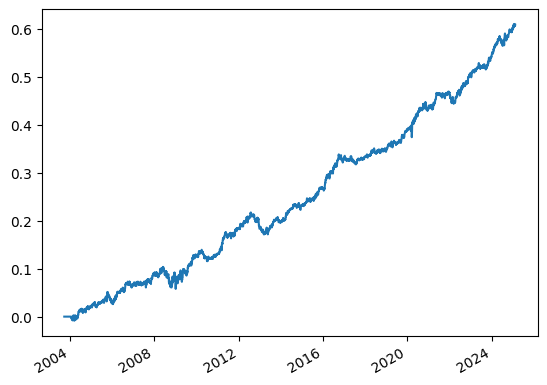

In [14]:
df_factor1 = pd.read_excel(output_path + 'NFL2_factor1_weights.xlsx', index_col=0)
df_factor2 = pd.read_excel(output_path + 'NFL2_factor2_weights.xlsx', index_col=0)

# 5-day lagging 
# 20-yr sharpe ratio | 15-yr sharpe ratio | 10-yr sharpe ratio
# 0.60 | 0.67 | 0.54

# 3-day lagging 
# 20-yr sharpe ratio | 15-yr sharpe ratio | 10-yr sharpe ratio
# 0.82 | 0.93 | 0.99

# 2-day lagging 
# 20-yr sharpe ratio | 15-yr sharpe ratio | 10-yr sharpe ratio
# 0.98 | 1.11 | 1.17

# 1-day lagging 
# 20-yr sharpe ratio | 15-yr sharpe ratio | 10-yr sharpe ratio
# 1.17 | 1.41 | 1.64

common_dates = df_factor1.index \
.intersection(df_factor2.index) 

df_factor1 = df_factor1.loc[common_dates]
df_factor2 = df_factor2.loc[common_dates]

df_weights = 0.5 * df_factor1 \
            + 0.5 * df_factor2 \

common_dates = df_usd_return.index.intersection(df_weights.index)
df_weights = df_weights.loc[common_dates]
df_usd_return_filtered = df_usd_return.loc[common_dates]

df_usd_return_filtered, df_weights = build_same_setting_dataframe(df_usd_return_filtered, df_weights)
df_portfolio_return = calc_portfolio_return(df_usd_return_filtered, df_weights, 1)

((df_portfolio_return['return'] + 1).cumprod() - 1).plot()
print((df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20050101','%Y%m%d'):]['return'].std() * np.sqrt(250)))
print((df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20100101','%Y%m%d'):]['return'].std() * np.sqrt(250)))
print((df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].mean()*250) / (df_portfolio_return.loc[datetime.strptime('20150101','%Y%m%d'):]['return'].std() * np.sqrt(250)))

# Number of Holdings

<Axes: >

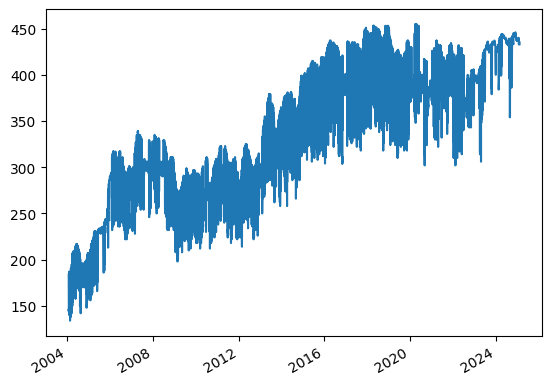

In [15]:
df_weights_filtered = df_weights.dropna(how='all')
df_weights_count = (df_weights_filtered != 0).astype(int).sum(axis=1) 
df_weights_count.plot()

# Portfolio Weight

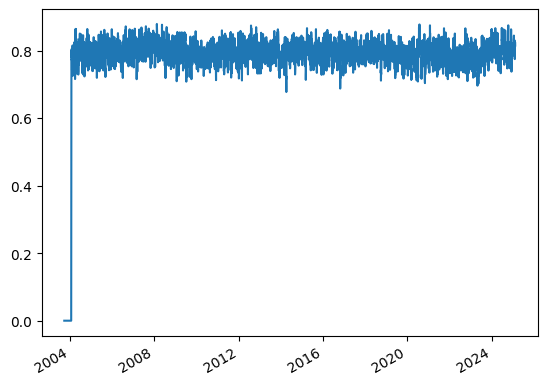

In [16]:
df_portfolio_weights = df_weights.abs().sum(axis=1).plot()

# Portfolio Turnover

0.29511877296835876


<Axes: >

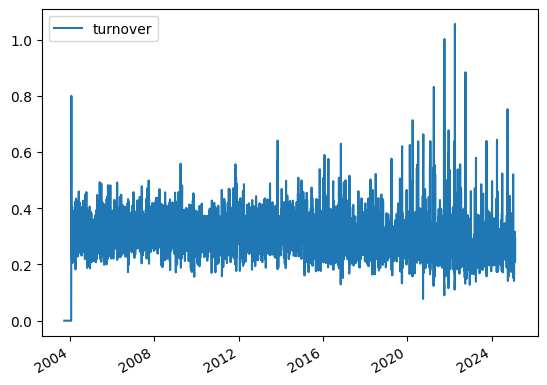

In [17]:
df_turnover = df_weights.fillna(0).diff().abs().sum(axis=1)
df_turnover = pd.DataFrame(df_turnover, columns = ['turnover'])
print(df_turnover['turnover'].mean())
df_turnover.plot()